In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import statsmodels.stats.api as sms
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

In [5]:
df_cust = pd.read_csv("customers.csv")
df_cs = pd.read_csv("credit_profiles.csv")
df_trans = pd.read_csv("transactions.csv")

In [6]:
df_cust.head()

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
0,1,Manya Acharya,Female,2,City,Business Owner,358211.0,Married
1,2,Anjali Pandey,Female,47,City,Consultant,65172.0,Single
2,3,Aaryan Chauhan,Male,21,City,Freelancer,22378.0,Married
3,4,Rudra Bali,Male,24,Rural,Freelancer,33563.0,Married
4,5,Advait Malik,Male,48,City,Consultant,39406.0,Married


In [7]:
df_cs.head()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
0,1,749,0.585171,19571.0,0.0,40000.0
1,2,587,0.107928,161644.0,2.0,1250.0
2,3,544,0.854807,513.0,4.0,1000.0
3,4,504,0.336938,224.0,2.0,1000.0
4,5,708,0.586151,18090.0,2.0,40000.0


In [8]:
df_trans.head()

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,705,2023-01-01,63,Flipkart,Electronics,Phonepe
1,2,385,2023-01-01,99,Alibaba,Fashion & Apparel,Credit Card
2,3,924,2023-01-01,471,Shopify,Sports,Phonepe
3,4,797,2023-01-01,33,Shopify,Fashion & Apparel,Gpay
4,5,482,2023-01-01,68,Amazon,Fashion & Apparel,Net Banking


In [9]:
print("Customers data",df_cust.shape)
print("Credit Score data",df_cs.shape)
print("Transactions data",df_trans.shape)

Customers data (1000, 8)
Credit Score data (1004, 6)
Transactions data (500000, 7)


# Phase 1: Identify the target group for a credit card launch 

## Analyzing Customers Table

In [10]:
df_cust.head(3)

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
0,1,Manya Acharya,Female,2,City,Business Owner,358211.0,Married
1,2,Anjali Pandey,Female,47,City,Consultant,65172.0,Single
2,3,Aaryan Chauhan,Male,21,City,Freelancer,22378.0,Married


In [11]:
df_cust.describe()

,cust_id,age,annual_income
count,1000.000000,1000.000000,950.000000
mean,500.500000,36.405000,139410.314737
std,288.819436,15.666155,112416.802007
min,1.000000,1.000000,2.000000
25%,250.750000,26.000000,47627.500000
50%,500.500000,32.000000,112218.500000
75%,750.250000,46.000000,193137.500000
max,1000.000000,135.000000,449346.000000


## Income 

### Handling Null Values

In [12]:
df_cust.isnull().sum()

cust_id            0
name               0
gender             0
age                0
location           0
occupation         0
annual_income     50
marital_status     0
dtype: int64

50 null values in annual_income. Let's quickly explore those rows

In [13]:
df_cust[df_cust.annual_income.isna()].head(4)

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
14,15,Sanjana Malik,Female,25,Rural,Artist,NaN,Married
82,83,Reyansh Mukherjee,Male,27,City,Freelancer,NaN,Single
97,98,Virat Puri,Male,47,Suburb,Business Owner,NaN,Married
102,103,Aarav Shah,Male,32,City,Data Scientist,NaN,Married


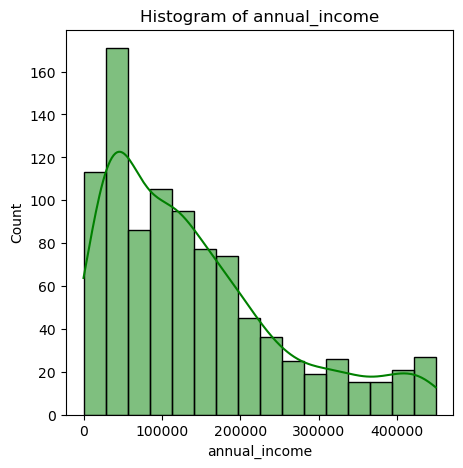

In [14]:
plt.figure(figsize=(5, 5))
sns.histplot(df_cust['annual_income'], kde=True, color='green', label='Data')
plt.title('Histogram of annual_income')
plt.show()

Since there are 50 of them in a dataframe of 1000, we will not remove them as we don't want to loose some important records.
Income data is skewed and the mean gets pulled up by high incomes. The median is more robust. People in different occupations tend to have very different typical incomes. For example, a “Business Owner” likely earns more on average than an “Artist.”

Imputing missing income using the median of the relevant occupation group is more realistic than using a global median for everyone.
This approach preserves the distribution within subgroups and maintains relationships in your data.

In [15]:
occupation_wise_inc_median = df_cust.groupby("occupation")["annual_income"].median()
occupation_wise_inc_median

occupation
Accountant              65265.0
Artist                  45794.0
Business Owner         261191.5
Consultant              58017.0
Data Scientist         135759.0
Freelancer              46759.0
Fullstack Developer     76774.0
Name: annual_income, dtype: float64

In [16]:
# 2. Replace null values in annual_income with the median income of their occupation group
df_cust['annual_income'] = df_cust.apply(
    lambda row: occupation_wise_inc_median[row['occupation']] if pd.isnull(row['annual_income']) else row['annual_income'],
    axis=1
)

In [17]:
df_cust.isnull().sum()

cust_id           0
name              0
gender            0
age               0
location          0
occupation        0
annual_income     0
marital_status    0
dtype: int64

Now that there are no null values, let us view the distribution of annual income

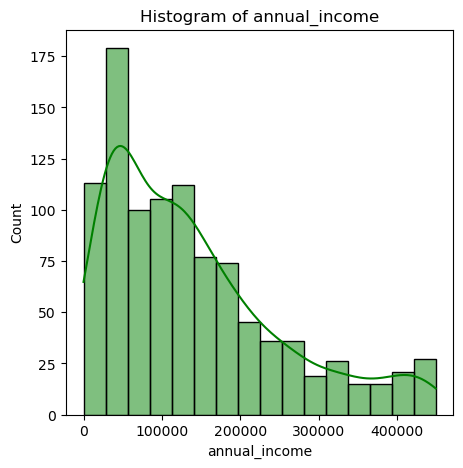

In [18]:
plt.figure(figsize=(5, 5))
sns.histplot(df_cust['annual_income'], kde=True, color='green', label='Data')
plt.title('Histogram of annual_income')
plt.show()

### Outlier Detection And Treatment

Above you can see above that the income distribution is right skewed

In [19]:
df_cust.describe()

,cust_id,age,annual_income
count,1000.000000,1000.000000,1000.000000
mean,500.500000,36.405000,138916.765500
std,288.819436,15.666155,110969.408643
min,1.000000,1.000000,2.000000
25%,250.750000,26.000000,48229.500000
50%,500.500000,32.000000,113416.000000
75%,750.250000,46.000000,192614.000000
max,1000.000000,135.000000,449346.000000


We have following observations from the above,

1. **Age**: min = 1, max = 135
1. **Annual Income**: min = 2, max = 447 k

Age column has outliers. Annual income also seem to have outliers in terms of minimum value because business suggested that minimum income should be atleast 100

In [20]:
df_cust.annual_income.describe()

count      1000.000000
mean     138916.765500
std      110969.408643
min           2.000000
25%       48229.500000
50%      113416.000000
75%      192614.000000
max      449346.000000
Name: annual_income, dtype: float64

Let us use standard deviation to detect outliers. Common practice is to treat anything that +/- 3 std dev as an outlier

In [21]:
df_cust['annual_income'].mean(), df_cust['annual_income'].std()

(np.float64(138916.7655), 110969.40864336627)

In [22]:
lower = df_cust['annual_income'].mean() - 3*df_cust['annual_income'].std()
upper = df_cust['annual_income'].mean() + 3*df_cust['annual_income'].std()

lower, upper

(np.float64(-193991.46043009878), np.float64(471824.9914300988))

In [23]:
df_cust[df_cust['annual_income']>upper]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status


We are seeing two outliers as per our statistical criteria of +/3 3 std deb. But we don't always assume these as outliers all the time. We have to use business knowledge and our sense of judgement. Here after discussing with the business we concluded that having this type of higher income for business owners is usual and we will keep these data points as is to stay close to the reality while doing our analysis.

On the lower end however, we see minimum income as 2. Our business manager has told us that the income should be at least 100. We can use this as our criteria to find out the outliers on the lower end. These outliers could have occured due to a data error.

In [24]:
df_cust[df_cust.annual_income<100]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
31,32,Veer Mistry,Male,50,City,Business Owner,50.0,Married
262,263,Vivaan Tandon,Male,53,Suburb,Business Owner,50.0,Married
316,317,Yuvraj Saxena,Male,47,City,Consultant,50.0,Married
333,334,Avani Khanna,Female,29,City,Data Scientist,50.0,Married
340,341,Priya Sinha,Female,33,Rural,Fullstack Developer,50.0,Married
543,544,Advait Batra,Male,54,City,Consultant,2.0,Married
592,593,Priya Gandhi,Female,32,City,Business Owner,50.0,Married
633,634,Rudra Mehtani,Male,26,City,Data Scientist,2.0,Married
686,687,Vihaan Jaiswal,Male,40,City,Business Owner,2.0,Married
696,697,Ishan Negi,Male,47,City,Consultant,20.0,Married


Above records (with <100$ income) are outliers. We have following options to treat them,

1. **Remove them**: After discussion with business, we decided not to remove them as these are valid customers and we want to include them in our analysis
1. **Replace them with mean or median** : Mean is sensitive to outliers. It is better to use median for income values
1. **Replace them with occupation wise median**: Income level may vary based on occupation. For example median income for data scientist can be different from a median income of a business owner. It is better to use occupation wise median income for replacement


In [25]:
for index, row in df_cust.iterrows():
    if row["annual_income"] < 100:
        occupation = df_cust.at[index, "occupation"]
        df_cust.at[index, "annual_income"] = occupation_wise_inc_median[occupation]

In [26]:
df_cust[df_cust.annual_income<100]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status


In [27]:
df_cust.loc[[112,256]]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
112,113,Yash Sethi,Male,55,City,Business Owner,303207.0,Married
256,257,Rohan Sethi,Male,28,City,Freelancer,205791.0,Married


Record at 112 and 256 location had annual income of < 100$. Now you can see it is replaced by a median income per occupation

### Data Visulaization

We will explore average income level based on occupation, gender, location and marital status

In [28]:
avg_income_per_occupation  = df_cust.groupby("occupation")["annual_income"].mean()
avg_income_per_occupation 

occupation
Accountant              64123.562500
Artist                  45309.236842
Business Owner         268447.368512
Consultant              60703.154639
Data Scientist         137021.266304
Freelancer              76327.508772
Fullstack Developer     78727.972973
Name: annual_income, dtype: float64

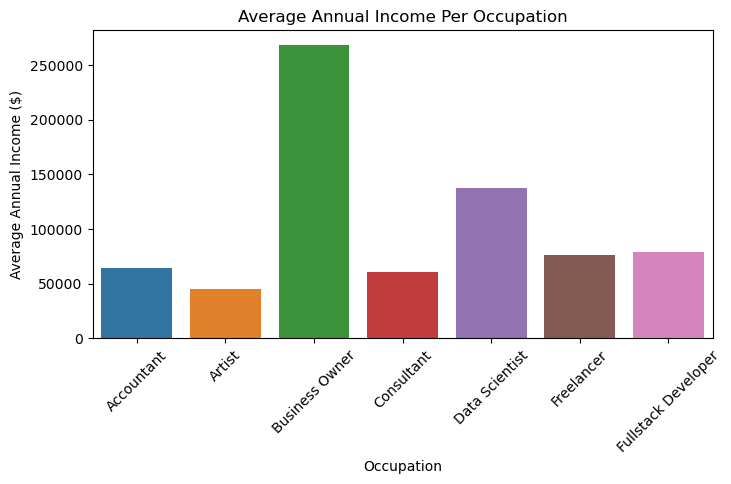

In [29]:
plt.figure(figsize=(8,4))
sns.barplot(x=avg_income_per_occupation.index, y=avg_income_per_occupation.values, palette='tab10')
plt.xticks(rotation=45)
plt.title('Average Annual Income Per Occupation')
plt.xlabel('Occupation')
plt.ylabel('Average Annual Income ($)')
plt.show()

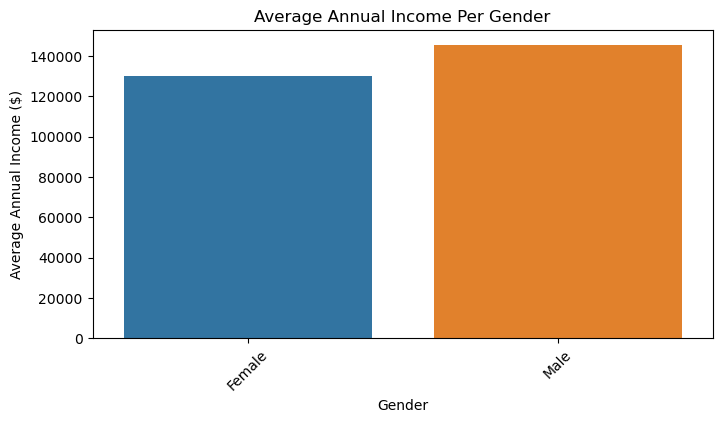

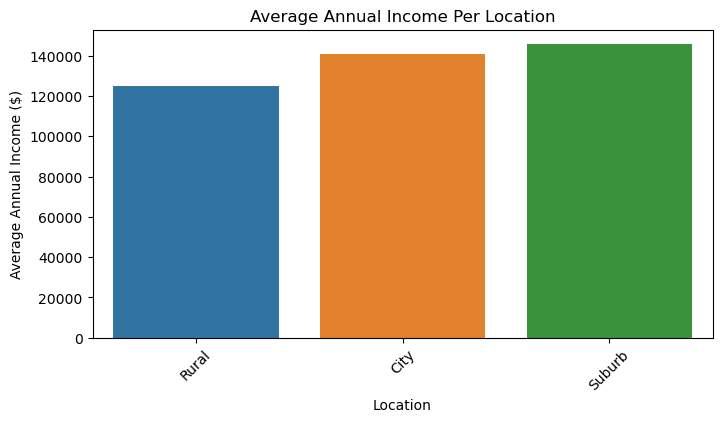

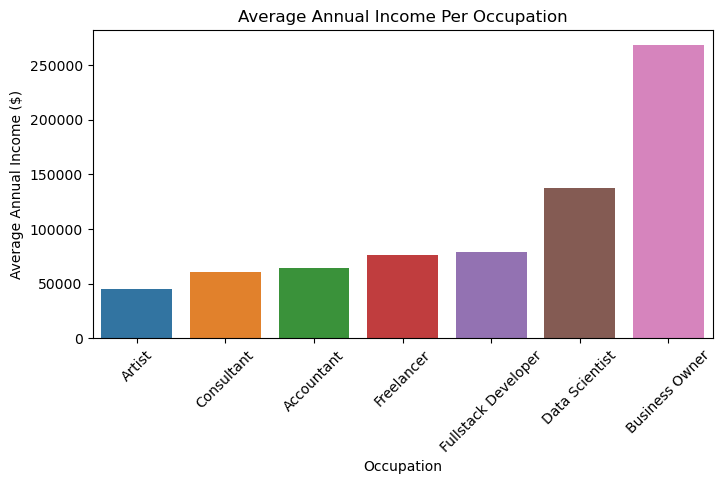

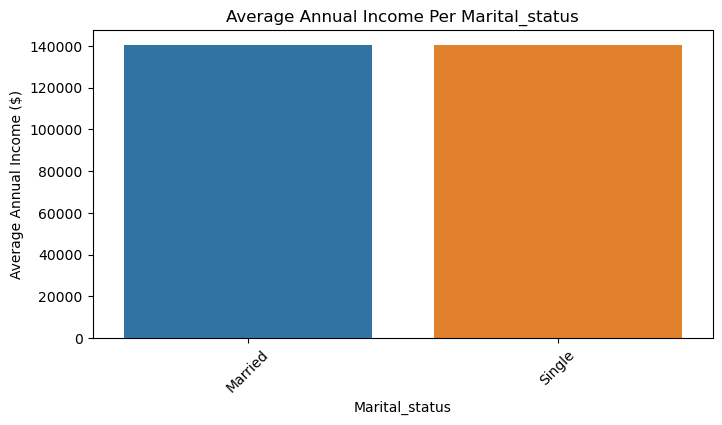

In [30]:
# List of categorical columns
categorical_columns = ['gender', 'location', 'occupation', 'marital_status']

# Loop through each categorical column and plot a bar chart of average annual income
for col in categorical_columns:
    plt.figure(figsize=(8, 4))
    avg_income_per_group = df_cust.groupby(col)['annual_income'].mean().sort_values()
    sns.barplot(x=avg_income_per_group.index, y=avg_income_per_group.values, palette='tab10')
    plt.xticks(rotation=45)
    plt.title(f'Average Annual Income Per {col.capitalize()}')
    plt.xlabel(col.capitalize())
    plt.ylabel('Average Annual Income ($)')
    plt.show()

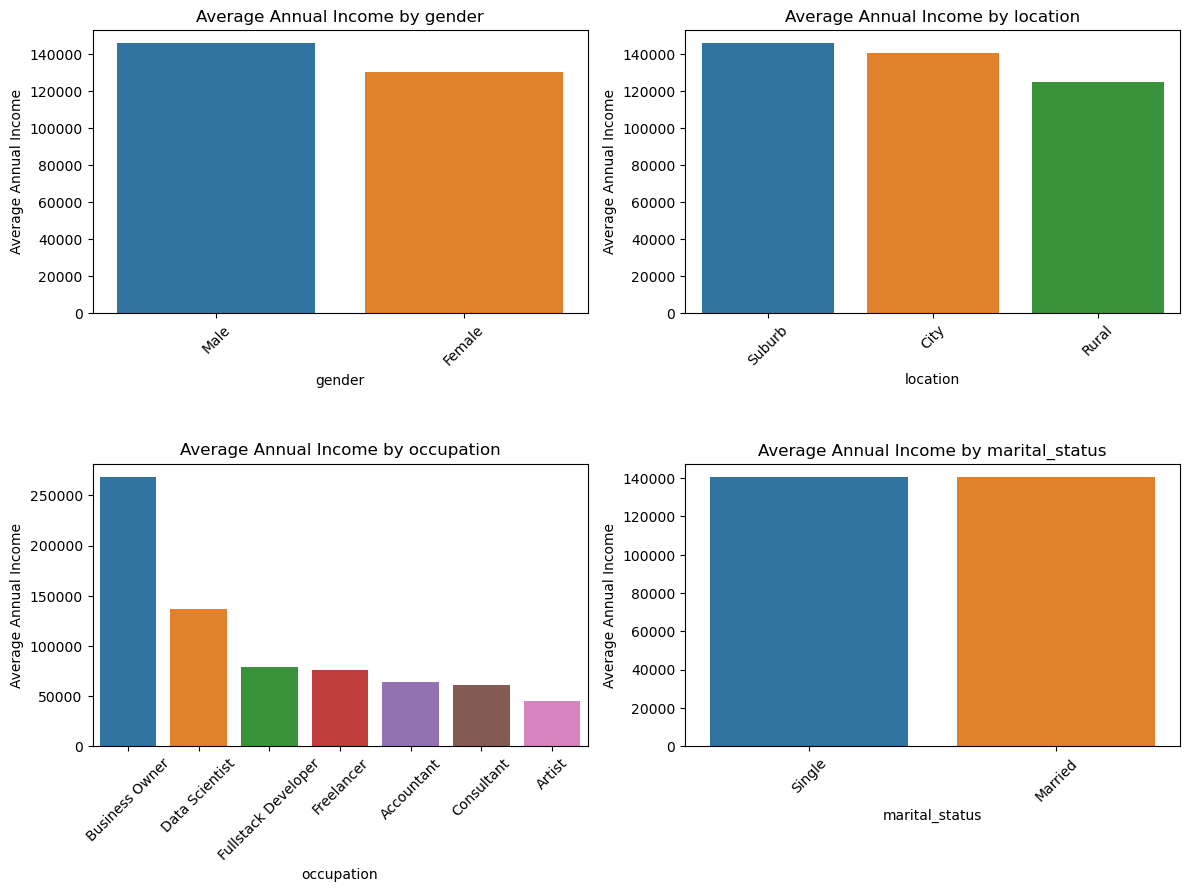

In [31]:
# List of categorical columns
cat_cols = ['gender', 'location', 'occupation', 'marital_status']

num_rows = 3
# Create subplots
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 4 * num_rows))

# Flatten the axes array to make it easier to iterate
axes = axes.flatten()

# Create subplots for each categorical column
for i, cat_col in enumerate(cat_cols):
    # Calculate the average annual income for each category
    avg_income_by_category = df_cust.groupby(cat_col)['annual_income'].mean().reset_index()
    
    # Sort the data by 'annual_income' before plotting
    sorted_data = avg_income_by_category.sort_values(by='annual_income', ascending=False)
    
    sns.barplot(x=cat_col, y='annual_income', data=sorted_data, ci=None, ax=axes[i], palette='tab10')
    axes[i].set_title(f'Average Annual Income by {cat_col}')
    axes[i].set_xlabel(cat_col)
    axes[i].set_ylabel('Average Annual Income')

    # Rotate x-axis labels for better readability
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

# Hide any unused subplots
for i in range(len(cat_cols), len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

## Age 

### Handling Null Values

In [32]:
df_cust.age.isnull().sum()

np.int64(0)

No null values are found in age column. This means we don't need to worry about handling them.

In [33]:
df_cust.describe()

,cust_id,age,annual_income
count,1000.000000,1000.000000,1000.000000
mean,500.500000,36.405000,140483.548500
std,288.819436,15.666155,110463.002934
min,1.000000,1.000000,5175.000000
25%,250.750000,26.000000,49620.500000
50%,500.500000,32.000000,115328.000000
75%,750.250000,46.000000,195514.250000
max,1000.000000,135.000000,449346.000000


### Outlier Detection And Treatment

Above we see that min age is 1 and max age is 135. These seem to be outliers. So let's find out age distribution.

In [34]:
min_age = df_cust.age.min()
max_age = df_cust.age.max()

min_age, max_age

(1, 135)

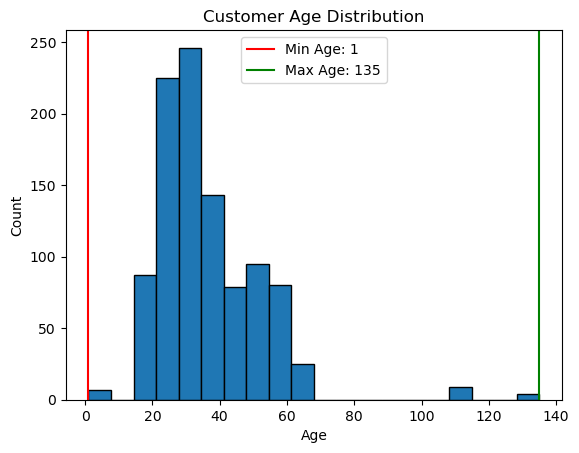

In [35]:
plt.hist(df_cust.age, bins=20, edgecolor='black')
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Customer Age Distribution")

plt.axvline(min_age, color="red", label=f"Min Age: {min_age}")
plt.axvline(max_age, color="green", label=f"Max Age: {max_age}")

plt.legend()
plt.show()

From above we will try to find out all customers above 80 and below 15.

In [36]:
df_cust[(df_cust.age<15)|(df_cust.age>80)]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
0,1,Manya Acharya,Female,2,City,Business Owner,358211.0,Married
41,42,Aaryan Shah,Male,110,City,Artist,7621.0,Married
165,166,Sia Dutta,Female,1,City,Freelancer,39721.0,Single
174,175,Rohan Sharma,Male,110,City,Freelancer,23723.0,Married
222,223,Arjun Batra,Male,110,Suburb,Freelancer,210987.0,Married
277,278,Aarav Tandon,Male,110,City,Consultant,96522.0,Single
295,296,Ayush Pandey,Male,1,Rural,Accountant,55254.0,Married
325,326,Virat Goel,Male,110,City,Accountant,61021.0,Single
610,611,Rehan Verma,Male,135,Rural,Business Owner,444776.0,Married
692,693,Dhruv Jha,Male,1,City,Business Owner,83045.0,Married


In [37]:
outliers = df_cust[(df_cust.age<15)|(df_cust.age>80)]
outliers.shape

(20, 8)

Total 20 outliers for age. Now how can we handle these outliers? 

Possible options,

1. Remove them: This doesn't sound like a good option as we will loose important information
1. Replace outlier values with some appropriate value: We can use mean or median for this

In [38]:
df_cust.age.median()

32.0

Instead of replace it with a median age for all customers, how about we calculate median age per occupation?

In [39]:
outliers.head(3)

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
0,1,Manya Acharya,Female,2,City,Business Owner,358211.0,Married
41,42,Aaryan Shah,Male,110,City,Artist,7621.0,Married
165,166,Sia Dutta,Female,1,City,Freelancer,39721.0,Single


As you can see, for business owners median age is 49 whereas artists have youngest age

We will calculte median per occupation and then use that for replacing outliers

In [40]:
median_age_per_occupation = df_cust.groupby('occupation')['age'].median()
median_age_per_occupation

occupation
Accountant             31.5
Artist                 26.0
Business Owner         51.0
Consultant             46.0
Data Scientist         32.0
Freelancer             24.0
Fullstack Developer    27.5
Name: age, dtype: float64

In [41]:
for index, row in outliers.iterrows():
    if pd.notnull(row['age']):
        occupation = df_cust.at[index, 'occupation']
        df_cust.at[index, 'age'] = median_age_per_occupation[occupation]

In [42]:
df_cust[(df_cust.age<15)|(df_cust.age>80)]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status


In [43]:
df_cust.age.describe()

count    1000.000000
mean       35.541500
std        12.276634
min        18.000000
25%        26.000000
50%        32.000000
75%        44.250000
max        64.000000
Name: age, dtype: float64

As you can see above, now we don't have any outliers left. min age is 18 and max is 64

In [44]:
df_cust.head()

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
0,1,Manya Acharya,Female,51.0,City,Business Owner,358211.0,Married
1,2,Anjali Pandey,Female,47.0,City,Consultant,65172.0,Single
2,3,Aaryan Chauhan,Male,21.0,City,Freelancer,22378.0,Married
3,4,Rudra Bali,Male,24.0,Rural,Freelancer,33563.0,Married
4,5,Advait Malik,Male,48.0,City,Consultant,39406.0,Married


### Data Visulaization

In [45]:
# Define the bin edges and labels
bin_edges = [17, 25, 48, 65]  # Adjust as needed
bin_labels = ['18-25', '26-48', '49-65']

# Use the cut function to bin and label the age column
pd.cut(df_cust['age'], bins=bin_edges, labels=bin_labels)

0      49-65
1      26-48
2      18-25
3      18-25
4      26-48
       ...  
995    26-48
996    49-65
997    26-48
998    26-48
999    26-48
Name: age, Length: 1000, dtype: category
Categories (3, object): ['18-25' < '26-48' < '49-65']

In [46]:
# Define the bin edges and labels
bin_edges = [17, 25, 48, 65]  # Adjust as needed
bin_labels = ['18-25', '26-48', '49-65']

# Use the cut function to bin and label the age column
df_cust['age_group'] = pd.cut(df_cust['age'], bins=bin_edges, labels=bin_labels)

In [47]:
df_cust.head()

,cust_id,name,gender,age,location,occupation,annual_income,marital_status,age_group
0,1,Manya Acharya,Female,51.0,City,Business Owner,358211.0,Married,49-65
1,2,Anjali Pandey,Female,47.0,City,Consultant,65172.0,Single,26-48
2,3,Aaryan Chauhan,Male,21.0,City,Freelancer,22378.0,Married,18-25
3,4,Rudra Bali,Male,24.0,Rural,Freelancer,33563.0,Married,18-25
4,5,Advait Malik,Male,48.0,City,Consultant,39406.0,Married,26-48


In [48]:
df_cust['age_group'].value_counts(normalize=True)*100

age_group
26-48    56.7
18-25    24.6
49-65    18.7
Name: proportion, dtype: float64

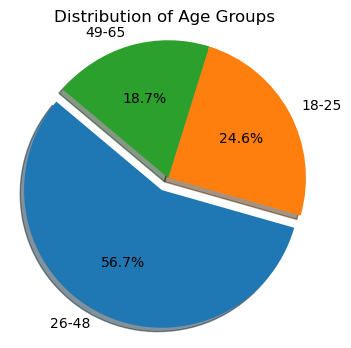

In [49]:
# Calculate the count of values in each age group
age_group_counts = df_cust['age_group'].value_counts(normalize=True) * 100

# Plot the pie chart
plt.figure(figsize=(4, 4))
plt.pie(
    age_group_counts, 
    labels=age_group_counts.index, 
    explode=(0.1,0,0), 
    autopct='%1.1f%%', 
    shadow=True,
    startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Age Groups')
plt.show()

##### More than 50% of customer base are in in age group of 26 - 48 adn ~26% are of age group 18 - 25

### Gender and Location Distribution

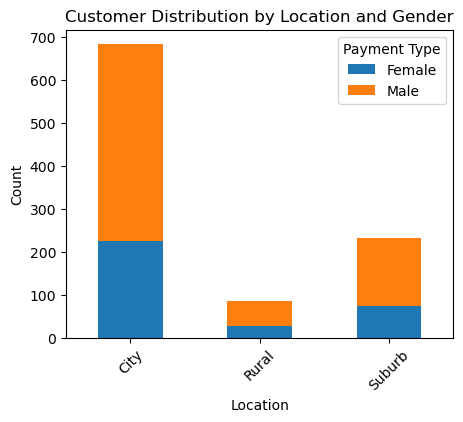

In [50]:
customer_location_gender = df_cust.groupby(['location', 'gender']).size().unstack(fill_value=0)

# Create a stacked bar chart to visualize the distribution of payment types for each occupation
customer_location_gender.plot(kind='bar', stacked=True, figsize=(5, 4))

# Add labels and title
plt.xlabel('Location')
plt.ylabel('Count')
plt.title('Customer Distribution by Location and Gender')

# Show the bar chart
plt.legend(title='Payment Type', bbox_to_anchor=(1, 1))  # Add a legend

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

plt.show()

## Analyzing Credit Score Table

In [51]:
df_cs.head()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
0,1,749,0.585171,19571.0,0.0,40000.0
1,2,587,0.107928,161644.0,2.0,1250.0
2,3,544,0.854807,513.0,4.0,1000.0
3,4,504,0.336938,224.0,2.0,1000.0
4,5,708,0.586151,18090.0,2.0,40000.0


### Duplicates

In [52]:
df_cs.shape

(1004, 6)

There are 1004 rows in this dataframe whereas customers dataframe had only 1000. There might be invalid or duplicate data in df_cs

In [53]:
df_cs['cust_id'].nunique()

1000

In [54]:
df_cs.duplicated('cust_id')

0       False
1       False
2       False
3       False
4       False
        ...  
999     False
1000    False
1001    False
1002    False
1003    False
Length: 1004, dtype: bool

df_cs[df_cs.duplicated('cust_id', keep=False)]

In [55]:
df_cs_clean_1 = df_cs.drop_duplicates(subset='cust_id', keep="last")
df_cs_clean_1.shape

(1000, 6)

In [56]:
df_cs_clean_1[df_cs_clean_1.duplicated('cust_id', keep=False)]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit


df_cs_clean_1 looks clean now after cleaning duplicates.

Next step would be to see if there are any null values

### Handle Null Values

In [57]:
df_cs_clean_1.isnull().sum()

cust_id                            0
credit_score                       0
credit_utilisation                 0
outstanding_debt                   0
credit_inquiries_last_6_months     0
credit_limit                      65
dtype: int64

It has a bunch of null values. we need to clean them up! From the business knowledge we know that credit limit depends on credit score of a customer. We will try to find out if we can figure out a mathematical relationship between credit score and credit limit and use credit score to full NULL values in credit limit. Let's explore a few things here!

In [58]:
df_cs_clean_1[df_cs_clean_1.credit_limit.isnull()]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
10,11,679,0.557450,9187.0,2.0,NaN
35,36,790,0.112535,4261.0,1.0,NaN
37,38,514,0.296971,238.0,2.0,NaN
45,46,761,0.596041,24234.0,2.0,NaN
64,65,734,0.473715,13631.0,0.0,NaN
...,...,...,...,...,...,...
912,909,479,0.487555,320.0,3.0,NaN
931,928,311,0.832244,316.0,2.0,NaN
948,945,526,0.272734,227.0,1.0,NaN
954,951,513,0.175914,131.0,3.0,NaN


In [59]:
df_cs_clean_1['credit_limit'].unique()

array([40000.,  1250.,  1000.,   500.,   750.,    nan,  1500., 60000.,
       20000.])

Credit limit has only few unique values. Let's check the count for each of these unique values

In [60]:
df_cs_clean_1['credit_limit'].value_counts()

credit_limit
500.0      229
60000.0    186
40000.0    137
1500.0     100
1000.0      90
750.0       76
1250.0      75
20000.0     42
Name: count, dtype: int64

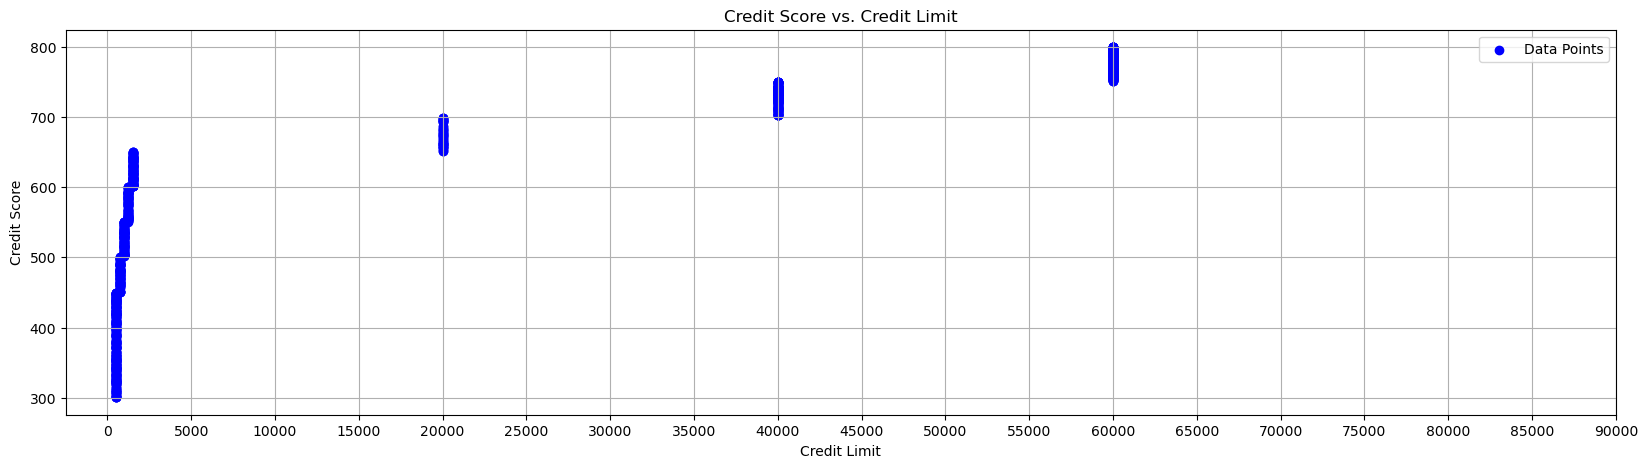

In [61]:
# Looking at scatter plot for credit score vs credit_limit again (after handling oultiers)
# Create a scatter plot
plt.figure(figsize=(20, 5))
plt.scatter(df_cs_clean_1['credit_limit'], df_cs_clean_1['credit_score'], c='blue', marker='o', label='Data Points')

# Customize the plot
plt.title('Credit Score vs. Credit Limit')
plt.xlabel('Credit Limit')
plt.ylabel('Credit Score')

# Adjust the y-axis bin interval to 1000
plt.xticks(range(0, 90001, 5000))
plt.grid(True)

# Show the plot
plt.legend()
plt.show()

Here we can see clear relationship between credit score and credit limit. Where there are levels for example, upto 650 score is getting a very minor credit limit (<1000$) where as a score between 650 to 700 is getting around 20000. Score between 700 to 750 is getting around 40K etc.

In [62]:
# Define bin ranges
bin_ranges = [300, 450, 500, 550, 600, 650, 700, 750, 800]

# Create labels for the bins
bin_labels = [f'{start}-{end-1}' for start, end in zip(bin_ranges, bin_ranges[1:])]

# Use pd.cut to assign data to bins
df_cs_clean_1['credit_score_range'] = pd.cut(df_cs_clean_1['credit_score'], bins=bin_ranges, labels=bin_labels, include_lowest=True, right=False)

In [63]:
df_cs_clean_1.head()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range
0,1,749,0.585171,19571.0,0.0,40000.0,700-749
1,2,587,0.107928,161644.0,2.0,1250.0,550-599
2,3,544,0.854807,513.0,4.0,1000.0,500-549
3,4,504,0.336938,224.0,2.0,1000.0,500-549
4,5,708,0.586151,18090.0,2.0,40000.0,700-749


We can now see a new column called credit_score_range whcih is calculated based on the credit_score column

In [64]:
df_cs_clean_1[['credit_score','credit_score_range', 'credit_limit']].head(3)

,credit_score,credit_score_range,credit_limit
0,749,700-749,40000.0
1,587,550-599,1250.0
2,544,500-549,1000.0


In [65]:
df_cs_clean_1[df_cs_clean_1['credit_score_range']=="750-799"]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range
21,22,785,0.897089,36083.0,3.0,60000.0,750-799
25,26,758,0.250811,190838.0,2.0,60000.0,750-799
26,27,766,0.830908,31344.0,3.0,60000.0,750-799
29,30,798,0.222597,7238.0,2.0,60000.0,750-799
31,32,768,0.747793,35109.0,2.0,60000.0,750-799
...,...,...,...,...,...,...,...
988,985,770,0.628088,33405.0,2.0,60000.0,750-799
993,990,772,0.259958,11937.0,2.0,60000.0,750-799
996,993,782,0.477170,20305.0,2.0,60000.0,750-799
1000,997,774,0.465462,17139.0,0.0,60000.0,750-799


In [66]:
df_cs_clean_1[df_cs_clean_1['credit_score_range']=="300-449"]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range
5,6,442,0.705409,246.0,4.0,500.0,300-449
11,12,429,0.627645,263.0,0.0,500.0,300-449
15,16,347,0.531660,190.0,0.0,500.0,300-449
18,19,447,0.795650,292.0,1.0,500.0,300-449
20,21,381,0.714710,307.0,0.0,500.0,300-449
...,...,...,...,...,...,...,...
981,978,371,0.435307,183.0,2.0,500.0,300-449
982,979,332,0.150815,65.0,1.0,500.0,300-449
984,981,327,0.377202,108.0,3.0,500.0,300-449
989,986,425,0.178470,56.0,4.0,500.0,300-449


Above you can see that for credit score range "750-799" the credit limit is 60K whereas for "300-449" it is 500. We can use MODE function to find out most frequently occuring credit limit for a given score range.

In [67]:
mode_df = df_cs_clean_1.groupby('credit_score_range')['credit_limit'].agg(lambda x: x.mode().iloc[0]).reset_index()
mode_df

,credit_score_range,credit_limit
0,300-449,500.0
1,450-499,750.0
2,500-549,1000.0
3,550-599,1250.0
4,600-649,1500.0
5,650-699,20000.0
6,700-749,40000.0
7,750-799,60000.0


In [68]:
df_cs_clean_1[df_cs_clean_1.credit_limit.isnull()].sample(3)

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range
948,945,526,0.272734,227.0,1.0,NaN,500-549
380,381,626,0.216894,235.0,0.0,NaN,600-649
306,307,304,0.254547,74.0,4.0,NaN,300-449


In [69]:
# Merge the mode values back with the original DataFrame
df_cs_clean_2 = pd.merge(df_cs_clean_1, mode_df, on='credit_score_range', suffixes=('', '_mode'))
df_cs_clean_2.sample(3)

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode
918,919,506,0.655158,570.0,1.0,1000.0,500-549,1000.0
744,745,799,0.780880,33767.0,2.0,60000.0,750-799,60000.0
614,615,776,0.278907,14937.0,0.0,NaN,750-799,60000.0


In [70]:
df_cs_clean_2[df_cs_clean_2.credit_limit.isnull()].sample(3)

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode
258,259,427,0.339428,136.0,4.0,NaN,300-449,500.0
206,207,771,0.162478,6595.0,3.0,NaN,750-799,60000.0
852,853,497,0.873269,416.0,3.0,NaN,450-499,750.0


Above we can simple replace NaN value in credit_limit column with credit_limit_mode value. This value indicates most frequently occuring credit limit for a given credit_score_range. Hence it can be used as a replacement value.

We will create a new copy of the dataframe so that we have reproducibility and access of the older dataframe in this notebook

In [71]:
df_cs_clean_3 = df_cs_clean_2.copy()
df_cs_clean_3['credit_limit'].fillna(df_cs_clean_3['credit_limit_mode'], inplace=True)
df_cs_clean_3.shape

(1000, 8)

In [72]:
df_cs_clean_3.isnull().sum()

cust_id                           0
credit_score                      0
credit_utilisation                0
outstanding_debt                  0
credit_inquiries_last_6_months    0
credit_limit                      0
credit_score_range                0
credit_limit_mode                 0
dtype: int64

You can now see ZERO outliers in credit_limit column which means we successfully got rid of all NULL values. Hurray! 🥳

In [73]:
df_cs_clean_3[df_cs_clean_3.cust_id==117]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode
116,117,372,0.604427,252.0,4.0,500.0,300-449,500.0


Previously customer id 5 had null value in credit_limit. Now it has a valid value

### Handling Outliers

In [74]:
df_cs_clean_3.describe()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_limit_mode
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,500.500000,589.182000,0.498950,9683.597000,1.955000,19733.75000,19912.500000
std,288.819436,152.284929,0.233139,25255.893671,1.414559,24717.43818,24840.914633
min,1.000000,300.000000,0.103761,33.000000,0.000000,500.00000,500.000000
25%,250.750000,460.000000,0.293917,221.000000,1.000000,750.00000,750.000000
50%,500.500000,601.500000,0.487422,550.000000,2.000000,1500.00000,1500.000000
75%,750.250000,738.000000,0.697829,11819.500000,3.000000,40000.00000,40000.000000
max,1000.000000,799.000000,0.899648,209901.000000,4.000000,60000.00000,60000.000000


When we observe min and max for various columns, we realize that outstanding_debt's max is greater than the max of credit_limit. Based on the business understanding, we know that the maximum debt that a customer can have is equal to credit limit. They would not be allowed to spend more than their credit limit. Let's see how many such cases are present in our dataset

Text(0.5, 1.0, 'Box plot for outstanding debt')

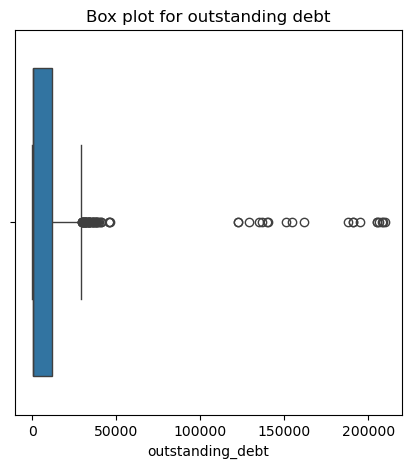

In [75]:
plt.figure(figsize=(5, 5))
sns.boxplot(x=df_cs_clean_3['outstanding_debt'])
plt.title('Box plot for outstanding debt')

Instead of using any statistical approach (such as standard deviation or IQR), here too we will use a business knowledge. We will mark any outstanding debt that is greater than credit limit as an outlier

In [76]:
df_cs_clean_3[df_cs_clean_3.outstanding_debt>df_cs_clean_3.credit_limit]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode
1,2,587,0.107928,161644.0,2.0,1250.0,550-599,1250.0
19,20,647,0.439132,205014.0,3.0,1500.0,600-649,1500.0
25,26,758,0.250811,190838.0,2.0,60000.0,750-799,60000.0
38,39,734,0.573023,122758.0,3.0,40000.0,700-749,40000.0
93,94,737,0.739948,137058.0,2.0,40000.0,700-749,40000.0
204,205,303,0.364360,187849.0,0.0,500.0,300-449,500.0
271,272,703,0.446886,154568.0,1.0,40000.0,700-749,40000.0
301,302,722,0.608076,122402.0,4.0,40000.0,700-749,40000.0
330,331,799,0.363420,208898.0,4.0,60000.0,750-799,60000.0
350,351,320,0.285081,150860.0,0.0,500.0,300-449,500.0


We will replace these outliers with credit_limit. We can assume that there was some data processing error due to we got these high numbers and it is ok to replace them with a credit_limit

In [77]:
df_cs_clean_3.loc[df_cs_clean_3['outstanding_debt'] > df_cs_clean_3['credit_limit'], 'outstanding_debt']

1      161644.0
19     205014.0
25     190838.0
38     122758.0
93     137058.0
204    187849.0
271    154568.0
301    122402.0
330    208898.0
350    150860.0
446    206191.0
544    135112.0
636    140063.0
646    128818.0
698    190717.0
723    140008.0
725    205404.0
730    209901.0
766    195004.0
862    208406.0
Name: outstanding_debt, dtype: float64

In [78]:
df_cs_clean_3.loc[df_cs_clean_3['outstanding_debt'] > df_cs_clean_3['credit_limit'], 'outstanding_debt'] = df_cs_clean_3['credit_limit']

In [79]:
df_cs_clean_3.loc[[55,66]]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode
55,56,429,0.198374,74.0,3.0,500.0,300-449,500.0
66,67,429,0.229638,69.0,4.0,500.0,300-449,500.0


In [80]:
df_cs_clean_3[df_cs_clean_3.outstanding_debt>df_cs_clean_3.credit_limit]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode


All outliers in column outstanding_debt are now GONE.

In [81]:
df_cs_clean_3.describe()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_limit_mode
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,500.500000,589.182000,0.498950,6850.084000,1.955000,19733.75000,19912.500000
std,288.819436,152.284929,0.233139,10683.473561,1.414559,24717.43818,24840.914633
min,1.000000,300.000000,0.103761,33.000000,0.000000,500.00000,500.000000
25%,250.750000,460.000000,0.293917,221.000000,1.000000,750.00000,750.000000
50%,500.500000,601.500000,0.487422,541.500000,2.000000,1500.00000,1500.000000
75%,750.250000,738.000000,0.697829,10924.500000,3.000000,40000.00000,40000.000000
max,1000.000000,799.000000,0.899648,60000.000000,4.000000,60000.00000,60000.000000


### Correlation Analysis

In [82]:
df_cust.head(2)

,cust_id,name,gender,age,location,occupation,annual_income,marital_status,age_group
0,1,Manya Acharya,Female,51.0,City,Business Owner,358211.0,Married,49-65
1,2,Anjali Pandey,Female,47.0,City,Consultant,65172.0,Single,26-48


In [83]:
df_cs_clean_3.head(2)

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode
0,1,749,0.585171,19571.0,0.0,40000.0,700-749,40000.0
1,2,587,0.107928,1250.0,2.0,1250.0,550-599,1250.0


In [84]:
df_merged = df_cust.merge(df_cs_clean_3, on='cust_id', how='inner')
df_merged.head(2)

,cust_id,name,gender,age,location,occupation,annual_income,marital_status,age_group,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode
0,1,Manya Acharya,Female,51.0,City,Business Owner,358211.0,Married,49-65,749,0.585171,19571.0,0.0,40000.0,700-749,40000.0
1,2,Anjali Pandey,Female,47.0,City,Consultant,65172.0,Single,26-48,587,0.107928,1250.0,2.0,1250.0,550-599,1250.0


In [85]:
numerical_cols = ['credit_score', 'credit_utilisation', 'outstanding_debt', 'credit_limit', 'annual_income','age']

correlation_matrix = df_merged[numerical_cols].corr()
correlation_matrix

,credit_score,credit_utilisation,outstanding_debt,credit_limit,annual_income,age
credit_score,1.000000,-0.070445,0.680654,0.847952,0.575751,0.444917
credit_utilisation,-0.070445,1.000000,0.192838,-0.080493,-0.086368,-0.027713
outstanding_debt,0.680654,0.192838,1.000000,0.810581,0.555661,0.444301
credit_limit,0.847952,-0.080493,0.810581,1.000000,0.684775,0.510993
annual_income,0.575751,-0.086368,0.555661,0.684775,1.000000,0.619037
age,0.444917,-0.027713,0.444301,0.510993,0.619037,1.000000


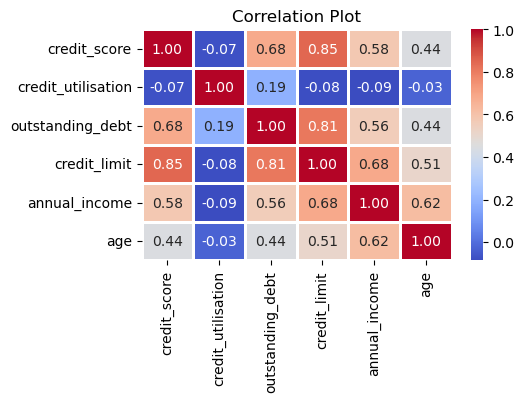

In [86]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(5, 3))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.8)
plt.title('Correlation Plot')
plt.show()

Credit Score and Credit Limit: There is a strong positive correlation (0.85) between credit score and credit limit, indicating that higher credit scores are associated with higher credit limits.

Outstanding Debt and Credit Limit: A high positive correlation (0.81) between outstanding debt and credit limit suggests that customers with higher credit limits tend to have higher outstanding debts.

Credit Score and Outstanding Debt: There is a moderate positive correlation (0.68) between credit score and outstanding debt, implying that customers with higher credit scores also tend to have higher outstanding debts.

Annual Income and Age: A moderate positive correlation (0.62) between annual income and age indicates that older customers tend to have higher annual incomes.

Credit Score and Annual Income: There is a moderate positive correlation (0.58) between credit score and annual income, suggesting that customers with higher incomes tend to have higher credit scores.

Credit Utilization: Credit utilization has weak correlations with other variables, indicating it varies independently of the other factors in this dataset.

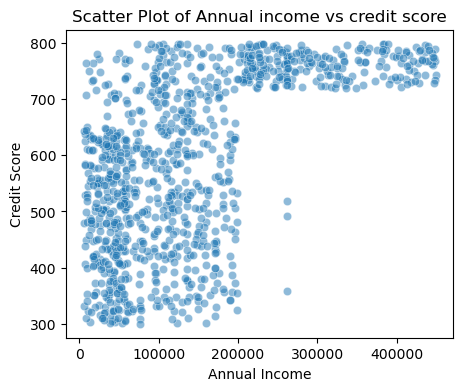

In [87]:
# Just looking if there is any relation between annual_income and credit score
plt.figure(figsize=(5, 4))
sns.scatterplot(x='annual_income', y='credit_score', data=df_merged, alpha=0.5)
plt.title('Scatter Plot of Annual income vs credit score')
plt.xlabel('Annual Income')
plt.ylabel('Credit Score')
plt.show()

These insights suggest a correlation between higher annual incomes and better credit scores, but the relationship is not strictly linear, as seen from the spread of credit scores within the lower income ranges.



## Analyzing Transactions Table

In [88]:
df_trans.head(2)

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,705,2023-01-01,63,Flipkart,Electronics,Phonepe
1,2,385,2023-01-01,99,Alibaba,Fashion & Apparel,Credit Card


In [89]:
df_trans.shape

(500000, 7)

### Handling Null Values

In [90]:
df_trans.isnull().sum()

tran_id                0
cust_id                0
tran_date              0
tran_amount            0
platform            4941
product_category       0
payment_type           0
dtype: int64

Platform has a lot of null values. Let's check them further

In [91]:
df_trans[df_trans.platform.isnull()]

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
355,356,58,2023-01-01,237,NaN,Electronics,Net Banking
418,419,383,2023-01-01,338,NaN,Electronics,Credit Card
607,608,421,2023-01-01,700,NaN,Electronics,Phonepe
844,845,945,2023-01-01,493,NaN,Sports,Credit Card
912,913,384,2023-01-01,85,NaN,Fashion & Apparel,Phonepe
...,...,...,...,...,...,...,...
499579,499580,924,2023-09-05,31,NaN,Fashion & Apparel,Gpay
499646,499647,944,2023-09-05,58445,NaN,Fashion & Apparel,Phonepe
499725,499726,620,2023-09-05,15,NaN,Sports,Net Banking
499833,499834,616,2023-09-05,97,NaN,Fashion & Apparel,Credit Card


<Axes: xlabel='count', ylabel='product_category'>

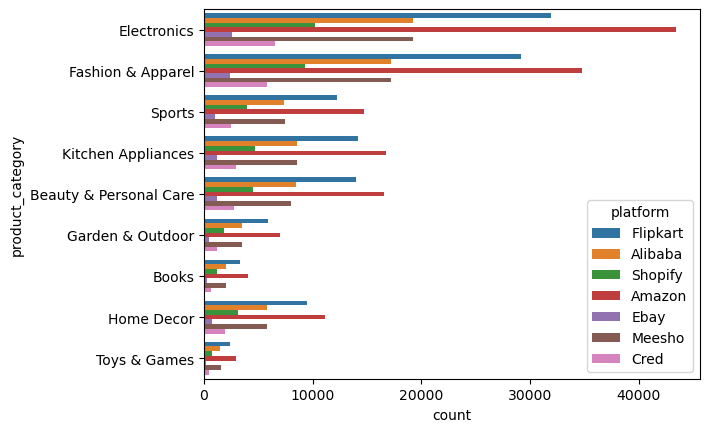

In [92]:
sns.countplot(y='product_category', hue='platform', data=df_trans)

Amazon Dominance: Amazon is the most frequently used platform for purchases across all product categories. This trend is consistent and prominent in categories such as Electronics, Fashion & Apparel, and Kitchen Appliances.

Other Platforms: While Amazon leads, other platforms like Flipkart, Alibaba, and Shopify also have significant usage in various categories. For instance, Flipkart shows a considerable count in Fashion & Apparel and Kitchen Appliances, while Alibaba has notable counts in Fashion & Apparel and Beauty & Personal Care.

Category Distribution: The distribution of product categories varies across platforms, but Electronics and Fashion & Apparel are the most commonly purchased categories overall.

Handling Null Values: Given Amazon's high frequency of use across all categories, replacing null values in the platform column with "Amazon" could be a reasonable approach to handle missing data.

These insights suggest that Amazon is the preferred platform for most customers, and other platforms have a varied but smaller share of transactions across different product categories.

In [93]:
df_trans.platform.mode()

0    Amazon
Name: platform, dtype: object

In [94]:
df_trans.platform.mode()[0]

'Amazon'

In [95]:
df_trans['platform'].fillna(df_trans.platform.mode()[0], inplace=True)

In [96]:
df_trans.isnull().sum()

tran_id             0
cust_id             0
tran_date           0
tran_amount         0
platform            0
product_category    0
payment_type        0
dtype: int64

### Outliers

In [97]:
df_trans.describe()

,tran_id,cust_id,tran_amount
count,500000.000000,500000.000000,500000.00000
mean,250000.500000,501.400428,3225.20733
std,144337.711634,288.641924,13098.74276
min,1.000000,1.000000,0.00000
25%,125000.750000,252.000000,64.00000
50%,250000.500000,502.000000,141.00000
75%,375000.250000,752.000000,397.00000
max,500000.000000,1000.000000,69999.00000


We can see transactions with 0 amount. These seem to be invalid

In [98]:
df_trans_zero = df_trans[df_trans.tran_amount==0]
df_trans_zero.head(3)

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
120,121,440,2023-01-01,0,Amazon,Electronics,Credit Card
141,142,839,2023-01-01,0,Amazon,Electronics,Credit Card
517,518,147,2023-01-01,0,Amazon,Electronics,Credit Card


In [99]:
df_trans_zero.shape

(4734, 7)

In [100]:
df_trans_zero.platform.value_counts()

platform
Amazon    4734
Name: count, dtype: int64

In [101]:
df_trans_zero[['platform','product_category','payment_type']].value_counts()

platform  product_category  payment_type
Amazon    Electronics       Credit Card     4734
Name: count, dtype: int64

It appears that when platform=Amazon, product_category=Eletronics and payment_type=Credit Card, at that time we get all these zero transactions. We need to find other transactions in this group and find its median to replace these zero values. We are not using mean because we can see some outliers as well in this column

In [102]:
df_trans_1 = df_trans[(df_trans.platform=='Amazon')&(df_trans.product_category=="Electronics")&(df_trans.payment_type=="Credit Card")]
df_trans_1.shape

(15637, 7)

In [103]:
df_trans_1[df_trans_1.tran_amount>0]

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
109,110,887,2023-01-01,635,Amazon,Electronics,Credit Card
173,174,676,2023-01-01,60439,Amazon,Electronics,Credit Card
190,191,763,2023-01-01,697,Amazon,Electronics,Credit Card
263,264,528,2023-01-01,421,Amazon,Electronics,Credit Card
311,312,936,2023-01-01,537,Amazon,Electronics,Credit Card
...,...,...,...,...,...,...,...
499766,499767,723,2023-09-05,909,Amazon,Electronics,Credit Card
499793,499794,586,2023-09-05,304,Amazon,Electronics,Credit Card
499812,499813,688,2023-09-05,425,Amazon,Electronics,Credit Card
499860,499861,373,2023-09-05,480,Amazon,Electronics,Credit Card


In [104]:
median_to_replace = df_trans_1[df_trans_1.tran_amount>0].tran_amount.median()
median_to_replace

554.0

In [105]:
df_trans['tran_amount'].replace(0,median_to_replace, inplace=True)

In [106]:
df_trans[df_trans.tran_amount==0]

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type


As you can see above, no zero values are left in tran_amount column

In [107]:
df_trans.tran_amount.describe()

count    500000.000000
mean       3230.452602
std       13097.561071
min           2.000000
25%          66.000000
50%         146.000000
75%         413.000000
max       69999.000000
Name: tran_amount, dtype: float64

In [108]:
df_trans[df_trans['tran_amount']<1000].describe()

,tran_id,cust_id,tran_amount
count,475000.000000,475000.000000,475000.000000
mean,250041.699922,501.375499,240.667608
std,144285.259913,288.606185,244.487110
min,1.000000,1.000000,2.000000
25%,125126.750000,252.000000,63.000000
50%,250100.500000,502.000000,131.000000
75%,374928.250000,751.000000,348.000000
max,500000.000000,1000.000000,999.000000


In [109]:
Q1, Q3 = df_trans['tran_amount'].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower = Q1 - 2 * IQR
upper = Q3 + 2 * IQR

lower, upper

(-628.0, 1107.0)

In [110]:
df_trans[df_trans.tran_amount<upper].tran_amount.max()

999

In [111]:
df_trans[df_trans.tran_amount>upper].tran_amount.min()

50000

In [112]:
df_trans_outliers = df_trans[df_trans.tran_amount>=upper]
df_trans_outliers

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
26,27,380,2023-01-01,61963,Shopify,Beauty & Personal Care,Credit Card
49,50,287,2023-01-01,57869,Amazon,Toys & Games,Gpay
94,95,770,2023-01-01,52881,Ebay,Kitchen Appliances,Credit Card
104,105,549,2023-01-01,58574,Flipkart,Fashion & Apparel,Gpay
113,114,790,2023-01-01,51669,Shopify,Kitchen Appliances,Credit Card
...,...,...,...,...,...,...,...
499742,499743,868,2023-09-05,55131,Meesho,Fashion & Apparel,Gpay
499888,499889,614,2023-09-05,59679,Meesho,Fashion & Apparel,Net Banking
499900,499901,811,2023-09-05,60184,Flipkart,Sports,Debit Card
499966,499967,662,2023-09-05,54678,Meesho,Sports,Gpay


In [113]:
df_trans_normal = df_trans[df_trans.tran_amount<upper]
df_trans_normal

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,705,2023-01-01,63,Flipkart,Electronics,Phonepe
1,2,385,2023-01-01,99,Alibaba,Fashion & Apparel,Credit Card
2,3,924,2023-01-01,471,Shopify,Sports,Phonepe
3,4,797,2023-01-01,33,Shopify,Fashion & Apparel,Gpay
4,5,482,2023-01-01,68,Amazon,Fashion & Apparel,Net Banking
...,...,...,...,...,...,...,...
499994,499995,679,2023-09-05,59,Ebay,Beauty & Personal Care,Gpay
499995,499996,791,2023-09-05,43,Amazon,Books,Phonepe
499997,499998,57,2023-09-05,224,Amazon,Garden & Outdoor,Phonepe
499998,499999,629,2023-09-05,538,Flipkart,Home Decor,Gpay


In [114]:
tran_mean_per_category = df_trans_normal.groupby("product_category")["tran_amount"].mean()
tran_mean_per_category

product_category
Beauty & Personal Care     92.167205
Books                      29.553515
Electronics               510.172685
Fashion & Apparel          64.553463
Garden & Outdoor          125.630277
Home Decor                302.487561
Kitchen Appliances        176.773288
Sports                    269.181631
Toys & Games               50.333298
Name: tran_amount, dtype: float64

In [115]:
df_trans.loc[df_trans_outliers.index]

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
26,27,380,2023-01-01,61963,Shopify,Beauty & Personal Care,Credit Card
49,50,287,2023-01-01,57869,Amazon,Toys & Games,Gpay
94,95,770,2023-01-01,52881,Ebay,Kitchen Appliances,Credit Card
104,105,549,2023-01-01,58574,Flipkart,Fashion & Apparel,Gpay
113,114,790,2023-01-01,51669,Shopify,Kitchen Appliances,Credit Card
...,...,...,...,...,...,...,...
499742,499743,868,2023-09-05,55131,Meesho,Fashion & Apparel,Gpay
499888,499889,614,2023-09-05,59679,Meesho,Fashion & Apparel,Net Banking
499900,499901,811,2023-09-05,60184,Flipkart,Sports,Debit Card
499966,499967,662,2023-09-05,54678,Meesho,Sports,Gpay


In [116]:
df_trans.loc[df_trans_outliers.index, 'tran_amount'] = df_trans_outliers['product_category'].map(tran_mean_per_category)

In [117]:
df_trans.loc[df_trans_outliers.index]

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
26,27,380,2023-01-01,92.167205,Shopify,Beauty & Personal Care,Credit Card
49,50,287,2023-01-01,50.333298,Amazon,Toys & Games,Gpay
94,95,770,2023-01-01,176.773288,Ebay,Kitchen Appliances,Credit Card
104,105,549,2023-01-01,64.553463,Flipkart,Fashion & Apparel,Gpay
113,114,790,2023-01-01,176.773288,Shopify,Kitchen Appliances,Credit Card
...,...,...,...,...,...,...,...
499742,499743,868,2023-09-05,64.553463,Meesho,Fashion & Apparel,Gpay
499888,499889,614,2023-09-05,64.553463,Meesho,Fashion & Apparel,Net Banking
499900,499901,811,2023-09-05,269.181631,Flipkart,Sports,Debit Card
499966,499967,662,2023-09-05,269.181631,Meesho,Sports,Gpay


You can now see that we got rid of outliers from tran_amount column.

<Axes: xlabel='tran_amount', ylabel='Count'>

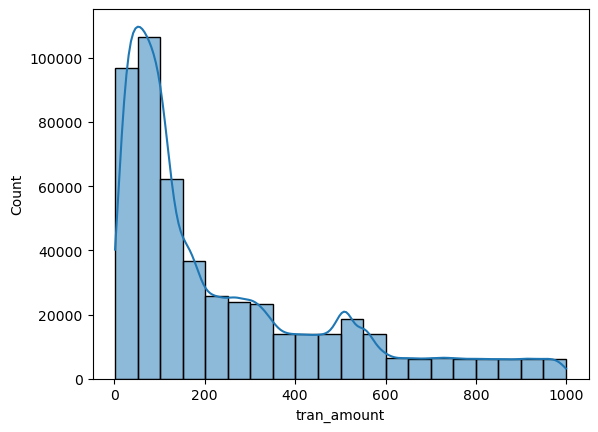

In [118]:
sns.histplot(x='tran_amount', data=df_trans, bins=20, kde=True)

Right-Skewed Distribution: The distribution of transaction amounts is right-skewed, with the majority of transactions being of smaller amounts.

High Frequency of Small Transactions: The highest frequency of transactions is within the lower range, particularly between 0 and 100.

Gradual Decline: There is a gradual decline in the number of transactions as the transaction amount increases.

Few High-Value Transactions: There are fewer high-value transactions, with the count significantly decreasing as the transaction amount approaches 1000.

### Data Visulaization

#### Payment Distribution

In [119]:
df_trans.head(3)

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,705,2023-01-01,63.0,Flipkart,Electronics,Phonepe
1,2,385,2023-01-01,99.0,Alibaba,Fashion & Apparel,Credit Card
2,3,924,2023-01-01,471.0,Shopify,Sports,Phonepe


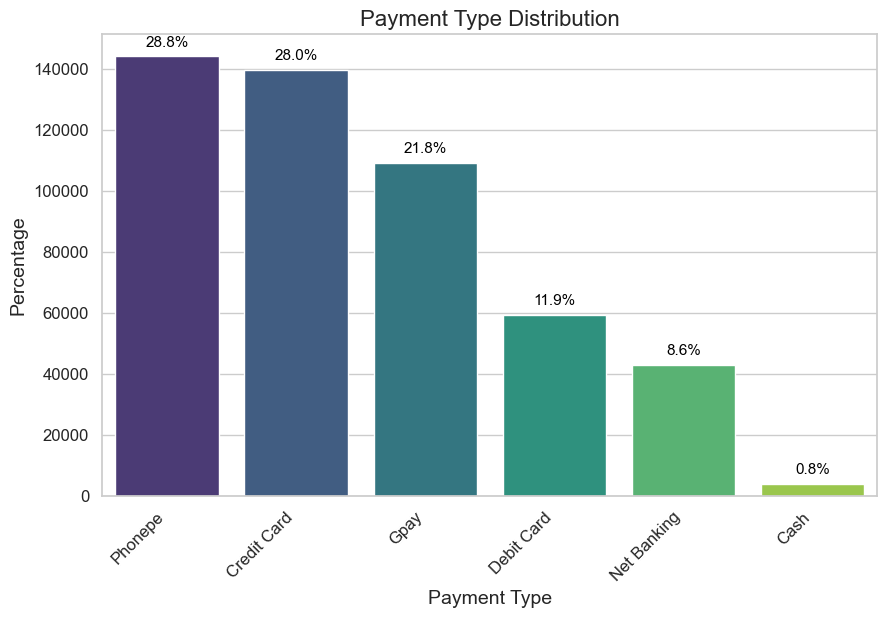

In [120]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a count plot of payment_type showing percentages
plt.figure(figsize=(10, 6))
sns.countplot(x=df_trans.payment_type, palette='viridis', order=df_trans.payment_type.value_counts().index)

# Add title and labels with improved styling
plt.title('Payment Type Distribution', fontsize=16)
plt.xlabel('Payment Type', fontsize=14)
plt.ylabel('Percentage', fontsize=14)

# Calculate the percentages and annotate the bars
total = len(df_trans)
for p in plt.gca().patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    plt.gca().annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=11, color='black', xytext=(0, 10),
                       textcoords='offset points')

# Improve the readability of the plot
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Phonepe and Credit Card: These are the most commonly used payment methods, each accounting for a significant portion of transactions (28.8% and 28.0%, respectively).

Gpay: This is also a popular payment method, making up 21.8% of the transactions.

Debit Card and Net Banking: These payment methods are used less frequently, with Debit Cards accounting for 11.9% and Net Banking for 8.6% of transactions.

Cash: This is the least used payment method, representing only 0.8% of transactions.

The plot indicates a strong preference for digital payment methods, with Phonepe, Credit Card, and Gpay collectively making up a significant majority of the transactions.

In [121]:
df_merged_2 = df_merged.merge(df_trans, on='cust_id', how='inner')
df_merged_2.head(3)

,cust_id,name,gender,age,location,occupation,annual_income,marital_status,age_group,credit_score,...,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode,tran_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,Manya Acharya,Female,51.0,City,Business Owner,358211.0,Married,49-65,749,...,0.0,40000.0,700-749,40000.0,1283,2023-01-01,30.0,Shopify,Fashion & Apparel,Net Banking
1,1,Manya Acharya,Female,51.0,City,Business Owner,358211.0,Married,49-65,749,...,0.0,40000.0,700-749,40000.0,1382,2023-01-01,96.0,Amazon,Sports,Debit Card
2,1,Manya Acharya,Female,51.0,City,Business Owner,358211.0,Married,49-65,749,...,0.0,40000.0,700-749,40000.0,1521,2023-01-01,86.0,Meesho,Garden & Outdoor,Gpay


In [122]:
df_merged_2.shape

(500000, 22)

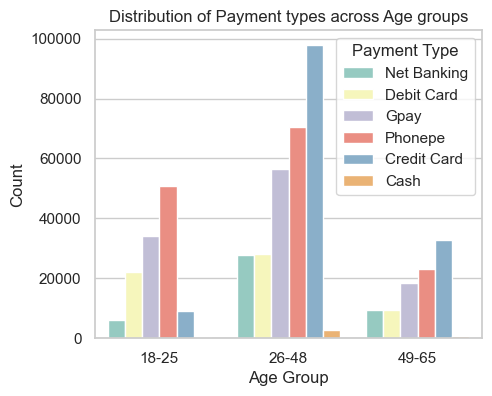

In [123]:
plt.figure(figsize=(5, 4))
sns.countplot(x='age_group', hue='payment_type', data=df_merged_2, palette='Set3')
plt.title('Distribution of Payment types across Age groups')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Payment Type', loc='upper right')

plt.show()

The distribution of payment types across age groups shows the following insights:

26-48 Age Group: This age group has the highest number of transactions across all payment types, with Credit Card being the most used method.

18-25 Age Group: This group primarily uses Phonepe and Gpay, indicating a preference for digital payment methods.

49-65 Age Group: Credit Card is also the most used payment method in this age group, followed by Gpay and Phonepe.

Overall, digital payment methods like Phonepe and Gpay are popular among younger age groups, while Credit Card usage is high across all age groups, particularly in the 26-48 range.Age group 18-25 has less exposure to credit cards compared to other groups

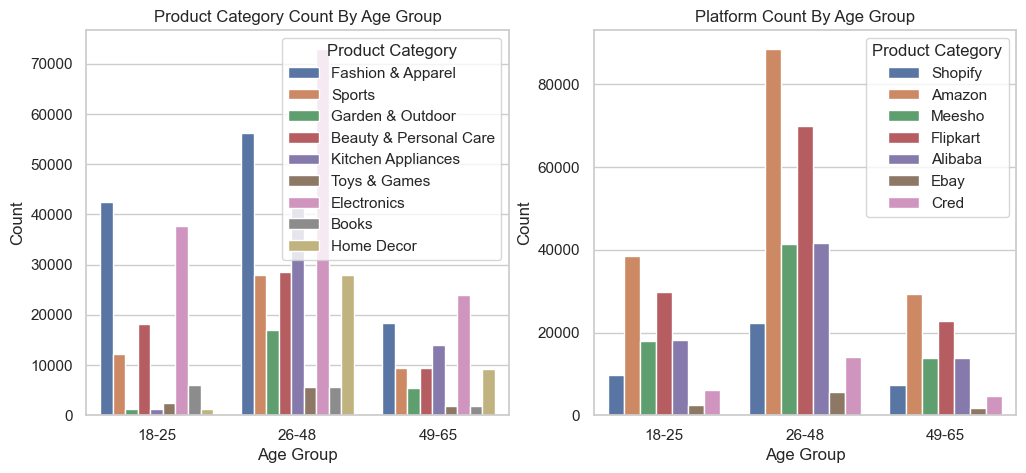

In [124]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

sns.countplot(x='age_group', hue="product_category", data=df_merged_2, ax=ax1)
ax1.set_title("Product Category Count By Age Group")
ax1.set_xlabel("Age Group")
ax1.set_ylabel("Count")
ax1.legend(title="Product Category", loc='upper right')

sns.countplot(x='age_group', hue="platform", data=df_merged_2, ax=ax2)
ax2.set_title("Platform Count By Age Group")
ax2.set_xlabel("Age Group")
ax2.set_ylabel("Count")
ax2.legend(title="Product Category", loc='upper right')

plt.show()

Top Product Categories: 18-25: Electronics, Fashion & Apparel, Beauty & Personal Care. 26-48: Electronics, Fashion & Apparel, Beauty & Personal Care. 49-65: Fashion & Apparel, Electronics, Kitchen Appliances.

Top Platforms: 18-25: Amazon, Flipkart, Gpay. 26-48: Amazon, Flipkart, Alibaba. 49-65: Amazon, Flipkart, Gpay.

Amazon dominates across all age groups, while Electronics and Fashion & Apparel are consistently popular product categories.

#### Average Transaction Amount

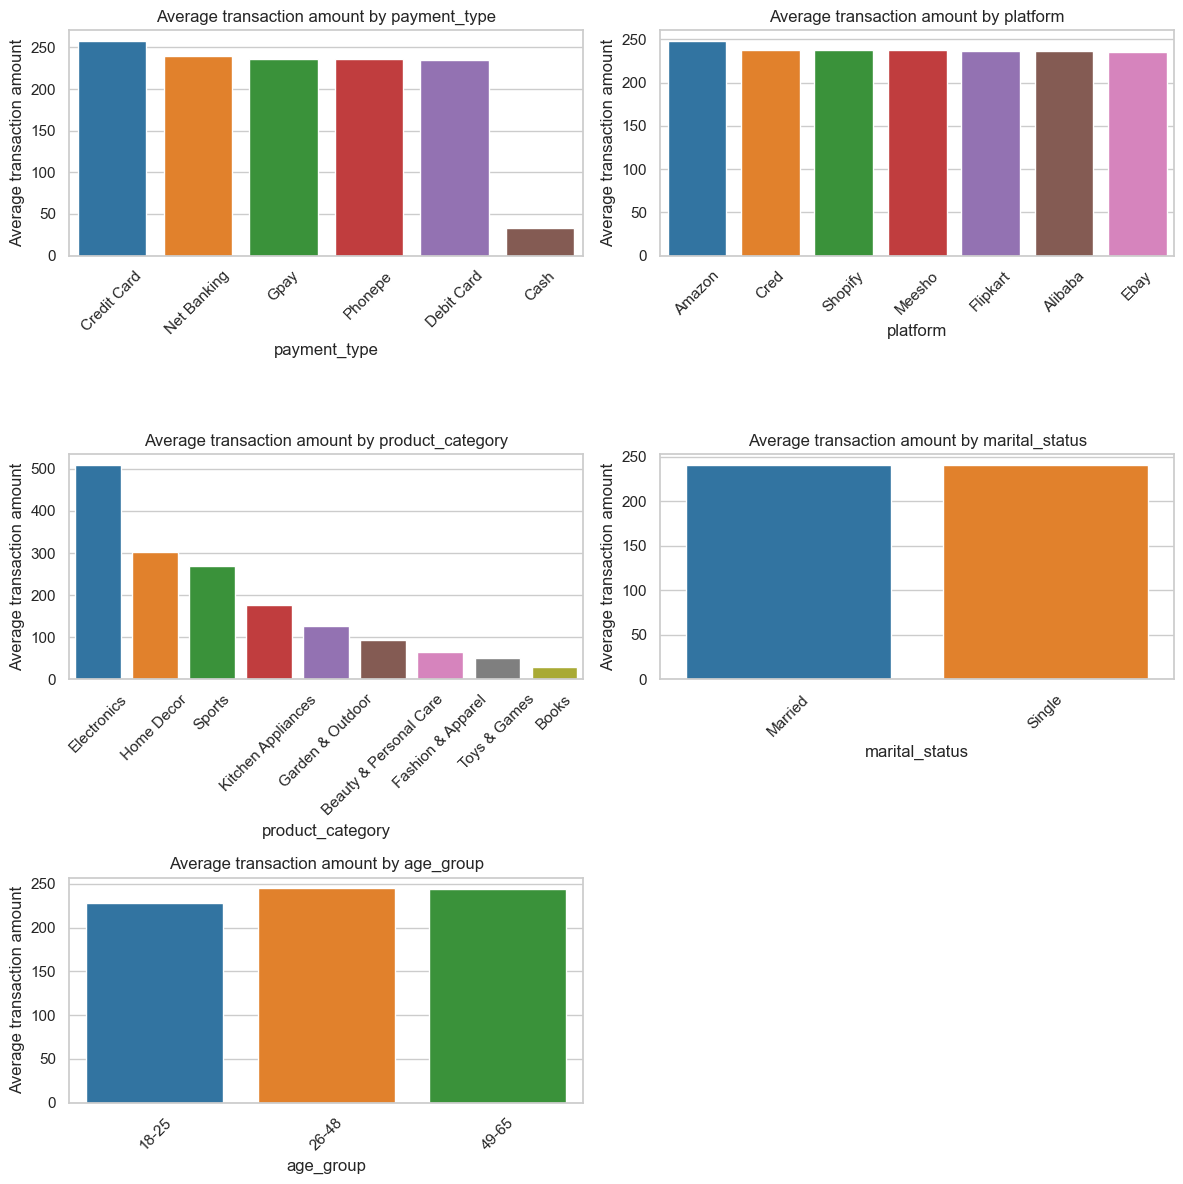

In [125]:
# List of categorical columns
cat_cols = ['payment_type', 'platform', 'product_category', 'marital_status', 'age_group']

num_rows = 3
# Create subplots
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 4 * num_rows))

# Flatten the axes array to make it easier to iterate
axes = axes.flatten()

# Create subplots for each categorical column
for i, cat_col in enumerate(cat_cols):
    # Calculate the average annual income for each category
    avg_tran_amount_by_category = df_merged_2.groupby(cat_col)['tran_amount'].mean().reset_index()
    
    # Sort the data by 'annual_income' before plotting
    sorted_data = avg_tran_amount_by_category.sort_values(by='tran_amount', ascending=False)
    
    sns.barplot(x=cat_col, y='tran_amount', data=sorted_data, ci=None, ax=axes[i], palette='tab10')
    axes[i].set_title(f'Average transaction amount by {cat_col}')
    axes[i].set_xlabel(cat_col)
    axes[i].set_ylabel('Average transaction amount')

    # Rotate x-axis labels for better readability
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

# Hide any unused subplots
for i in range(len(cat_cols), len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

In [126]:
df_trans.describe()

,tran_id,cust_id,tran_amount
count,500000.000000,500000.000000,500000.000000
mean,250000.500000,501.400428,240.672998
std,144337.711634,288.641924,241.696597
min,1.000000,1.000000,2.000000
25%,125000.750000,252.000000,64.553463
50%,250000.500000,502.000000,133.000000
75%,375000.250000,752.000000,349.000000
max,500000.000000,1000.000000,999.000000


#### Age

In [127]:
# Group the data by age group and calculate the average credit_limit and credit_score
age_group_metrics = df_merged.groupby('age_group')[['annual_income', 'credit_limit', 'credit_score']].mean().reset_index()
age_group_metrics

,age_group,annual_income,credit_limit,credit_score
0,18-25,37091.235772,1130.081301,484.451220
1,26-48,145869.623457,20560.846561,597.569665
2,49-65,260165.925134,41699.197861,701.524064


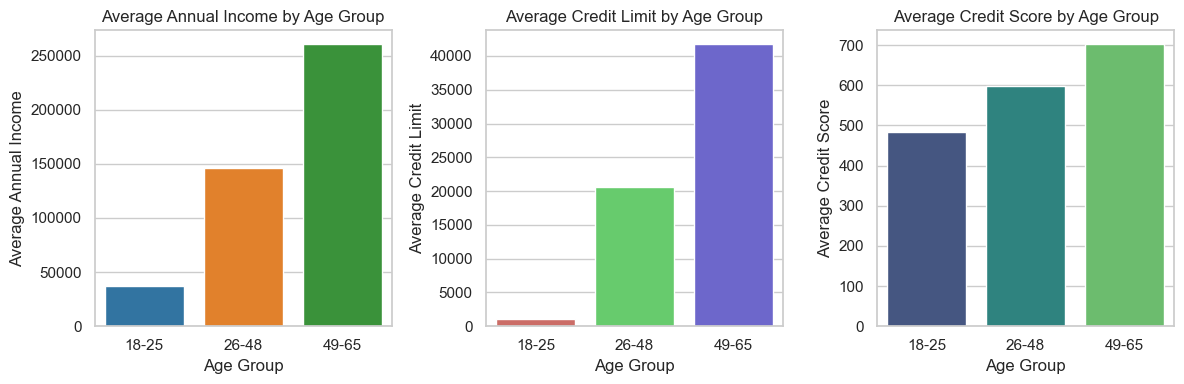

In [128]:
# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# Plot 1: Average annual income by age group
sns.barplot(x='age_group', y='annual_income', data=age_group_metrics, palette='tab10', ax=ax1)
ax1.set_title('Average Annual Income by Age Group')
ax1.set_xlabel('Age Group')
ax1.set_ylabel('Average Annual Income')
ax1.tick_params(axis='x', rotation=0)

# Plot 2: Average Max Credit Limit by Age Group
sns.barplot(x='age_group', y='credit_limit', data=age_group_metrics, palette='hls', ax=ax2)
ax2.set_title('Average Credit Limit by Age Group')
ax2.set_xlabel('Age Group')
ax2.set_ylabel('Average Credit Limit')
ax2.tick_params(axis='x', rotation=0)

# Plot 3: Average Credit Score by Age Group
sns.barplot(x='age_group', y='credit_score', data=age_group_metrics, palette='viridis', ax=ax3)
ax3.set_title('Average Credit Score by Age Group')
ax3.set_xlabel('Age Group')
ax3.set_ylabel('Average Credit Score')
ax3.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# Insights

1. People with age group of 18 -25 accounts to ~26% of customer base in the data
2. Avg annual income of this group is less than 50k
3. They don't have much credit history which is getting reflected in their credit score and credit limit 
4. Usage of credit cards as payment type is relatively low compared to other groups
5. Top 3 most shopping products categories : Electronics, Fashion & Apparel, Beauty & Personal care

# Phase 2: A/B Testing to determine whether the new card has a positive impact on usage and transaction amounts.

## (1) Pre-Campaign

To conduct a trial run for the new credit card, it is necessary to determine the number of customers required for A/B testing. This involves forming both a control and a test group. The number of customers in each group will be based on the agreed-upon statistical power and effect size, following discussions with the business team.

In [155]:
# Define parameters for power analysis
alpha = 0.05  # 5% significance level
power = 0.8  # 80% power
effect_size = 0.2  # Effect size of 0.2

# Calculate the required sample size for each group in A/B testing
sample_size = sms.tt_ind_solve_power(
    effect_size=effect_size,
    alpha=alpha,
    power=power,
    ratio=1,
    alternative='two-sided'
)

sample_size

393.4056930002514

For an effect size of 0.2, 393 customers are needed. Budgeting restrictions must be considered when running this campaign. It is advisable to run the analysis for different effect sizes and discuss with the business team to determine the optimal sample size.



In [156]:
# List of effect sizes to calculate the required sample size for each
effect_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 1]  # Standard deviations greater than the control group

# Calculate and print the required sample size for each effect size
for effect_size in effect_sizes:
    sample_size = sms.tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, ratio=1, alternative='two-sided')
    print(f"Effect Size: {effect_size}, Required Sample Size: {int(sample_size)} customers")  # Print effect size and corresponding sample size

Effect Size: 0.1, Required Sample Size: 1570 customers
Effect Size: 0.2, Required Sample Size: 393 customers
Effect Size: 0.3, Required Sample Size: 175 customers
Effect Size: 0.4, Required Sample Size: 99 customers
Effect Size: 0.5, Required Sample Size: 63 customers
Effect Size: 1, Required Sample Size: 16 customers


Based on business requirements, the test should be capable of detecting a minimum 0.4 standard deviation difference between the control and test groups. For the effect size 0.4, we need 100 customers and when we discussed with business, 100 customers is ok in terms of their budgeting constraints for this trail run

Approximately 246 customers within the age group of 18 to 25 have been identified. From this pool, 100 customers will be selected for the initial campaign launch.

The campaign will be launched for 100 customers, as determined by the effect size calculation and budgeting considerations, and will run for a duration of 2 months.

The campaign achieved a conversion rate of approximately 40%, meaning 40 out of 100 customers in the test group started using the credit card.

To maintain a similar sample size, a control group consisting of 40 customers will be created. This control group will be entirely separate from the initial 100 customers used in the test group.

Now, there are 40 customers in each of the control and test groups.

At the end of the 2-month campaign period (from 09-10-23 to 11-10-23), daily data was obtained showing the average transaction amounts made by the entire group of 40 customers in both the control and test groups using existing and newly launched credit cards, respectively.

The key performance indicator (KPI) for this A/B test aims to enhance the average transaction amounts facilitated by the new card.

 ## (2) Post-Campaign

### Two Sample Z Test for Our Hypothesis Testing


In [157]:
df_avg_trans = pd.read_csv("avg_transactions_after_campaign.csv")

In [158]:
df_avg_trans.head()

,campaign_date,control_group_avg_tran,test_group_avg_tran
0,2023-09-10,259.83,277.32
1,2023-09-11,191.27,248.68
2,2023-09-12,212.41,286.61
3,2023-09-13,214.92,214.85
4,2023-09-14,158.55,344.08


In [159]:
df_avg_trans.shape

(62, 3)

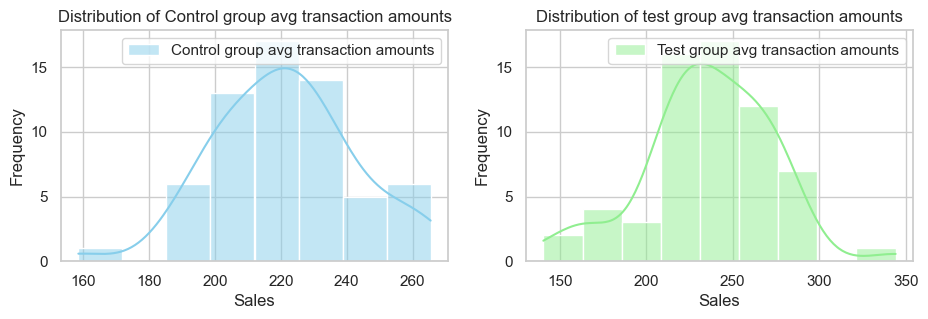

In [160]:
# Let's look at distributions of avg transactions amounts in both groups
# Create a 1x2 grid of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 3))

# Plot the distribution of Campaign A Sales
sns.histplot(df_avg_trans['control_group_avg_tran'], kde=True, color='skyblue', label='Control group avg transaction amounts', ax=ax1)
ax1.set_xlabel('Sales')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Control group avg transaction amounts')
ax1.legend()

# Plot the distribution of Campaign B Sales
sns.histplot(df_avg_trans['test_group_avg_tran'], kde=True, color='lightgreen', label='Test group avg transaction amounts', ax=ax2)
ax2.set_xlabel('Sales')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of test group avg transaction amounts')
ax2.legend()

# Show the plots
plt.show()

### Hypotheses:
Null Hypothesis (H0): The new credit card does not significantly increase the usage or transaction amounts compared to the existing credit card.

Alternative Hypothesis (H1): The new credit card significantly increases the usage or transaction amounts compared to the existing credit card.

In [161]:
# Safe rounding using built-in function
control_mean = round(df_avg_trans["control_group_avg_tran"].mean(), 2)
control_std = round(df_avg_trans["control_group_avg_tran"].std(), 2)
control_mean, control_std

(np.float64(221.18), 21.36)

In [162]:
# Calculate and round the mean and standard deviation of the test group's average transactions
test_mean = round(df_avg_trans["test_group_avg_tran"].mean(),2)
test_std = round(df_avg_trans["test_group_avg_tran"].std(), 2)

# Output the calculated mean and standard deviation for the test group
test_mean, test_std

(np.float64(235.98), 36.66)

In [163]:
# Calculate the sample size by getting the number of rows in the dataset
sample_size = df_avg_trans.shape[0]

# Output the sample size
sample_size

62

### Test Using Rejection Region (Critical Z Value)

In [164]:
# Calculate the variance divided by the sample size for both control and test groups
a = (control_std**2 / sample_size)
b = (test_std**2 / sample_size)

# Calculate the Z-score for the difference in means between the test and control groups
Z_score = (test_mean - control_mean) / np.sqrt(a + b)

# Output the calculated Z-score
Z_score

np.float64(2.7466072001806734)

In [165]:
# For a significance level of 5% (0.05) in a right-tailed test, the critical Z-value is approximately 1.645
critical_z_value = st.norm.ppf(1 - alpha)  # Right-tailed test at 5% significance level
critical_z_value

np.float64(1.6448536269514722)

In [166]:
# Compare the calculated Z-score with the critical Z-value to determine statistical significance
Z_score > critical_z_value

np.True_

Since Z score is higher than critical Z value, we can reject the null hypothesis.

### Test Using p-Value

In [167]:
# Calculate the p-value corresponding to z score for a right-tailed test
p_value = 1 - st.norm.cdf(Z_score)
p_value

np.float64(0.0030107601919702187)

In [168]:
p_value < alpha # p value is less than significance level of 5% (or 0.05 for absolute value)

np.True_

Since p value is less than significance level (alpha), we can reject the null hypothesis.

**Using Ready Made API call**

The stats module from statsmodels will be used for performing a Z-test.

The order in which control and test group data are passed to sm.stats.ztest(test_data, control_data) defines the test direction and influences the results.

Passing the test group data first assumes the alternative hypothesis that the mean of the test group is greater than the mean of the control group.

Conversely, switching the order assumes the alternative hypothesis that the control group average is greater than the test group average.

The order will be sm.stats.ztest(test_group_data, control_group_data) based on the alternative hypothesis considered above.

By default, the z-test module in statsmodels performs a two-tailed test. As a one-tailed test is being performed based on the direction and alternative hypothesis, the "alternative" parameter needs to be set accordingly.

Based on the test direction, the "alternative" parameter will be set to larger.

In [169]:
# Performing Z-test with above considerations
z_statistic, p_value = sm.stats.ztest( df_avg_trans['test_group_avg_tran'],df_avg_trans['control_group_avg_tran'],alternative = 'larger')
z_statistic, p_value

(np.float64(2.7482973745691135), np.float64(0.002995282462202502))

Conclusions:
Therefore, based on the results of the Z-test, the null hypothesis (H0) is rejected in favor of the alternative hypothesis (H1). This indicates that the new credit card has a statistically significant positive impact on the usage or transaction amounts compared to the existing credit card.